# Task D (TransE, PROV, PageRank):

#### Imports

In [56]:
from prov.model import ProvDocument, Namespace, Literal, PROV
from prov.model import ProvEntity, ProvActivity, ProvAgent, ProvRelation, ProvGeneration, ProvUsage, ProvAttribution, ProvAssociation, ProvInfluence, ProvDelegation, ProvDerivation, ProvCommunication
from prov.dot import prov_to_dot
from IPython.display import Image
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from graphviz import Source
from prov.graph import prov_to_graph
from pykeen.pipeline import pipeline
from pykeen.models import TransE, CompGCN
from pykeen.sampling import BasicNegativeSampler
from pykeen.evaluation import RankBasedEvaluator
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
from torch.utils.tensorboard import SummaryWriter
from pykeen.datasets import CoDExMedium
from pykeen.triples import TriplesFactory
import pykeen.datasets
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score
from torch_geometric.data import Data
from sklearn.manifold import TSNE
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import random

1) How would you represent such an event using the W3C PROV provenance data model
standar
? What would correspond to Agents, Entities, and Activitie ? Provide aidiagr m
illustrating your modelling, and create a (not necessarily spatial) network with ( ot
necessarily real) data, with at least 20 nodes in 1 single connected component.

Entity : Accident, Accident Location, Vehicle Involved, Casualty, Accident Report, Lighting Condition

Activity : Accident Occurance, Accident Investigation, Emergency Response

Agents : Police Officer , Driver, Witness

In [2]:
doc = ProvDocument()

In [3]:
# Defining namespaces for entities, activities, and agents
doc.add_namespace('road_events', 'http://leeds.gov.uk/road_events/')
doc.add_namespace('accident', 'http://leeds.gov.uk/accident/')
doc.add_namespace('marathon', 'http://leeds.gov.uk/marathon/')
doc.add_namespace('road_maintainance', 'http://leeds.gov.uk/road_maintainance/')
doc.add_namespace('protest', 'http://leeds.gov.uk/protest/')
doc.add_namespace('public_transport_strike', 'http://leeds.gov.uk/public_transport_strike/')

<Namespace: public_transport_strike {http://leeds.gov.uk/public_transport_strike/}>

In [4]:
#Entities

# Accident
accident_location = doc.entity('accident:AccidentLocation', {'prov:label': 'Accident Location'})
vehicle_involved = doc.entity('accident:VehicleInvolved', {'prov:label': 'Vehicle Involved'})
accident_casualty = doc.entity('accident:Casualty', {'prov:label': 'Accident Casualty'})
accident_report = doc.entity('accident:AccidentReport', {'prov:label': 'Accident Report'})

# Marathon
marathon_route = doc.entity('marathon:Route', {'prov:label': 'Marathon Route'})

# Road Maintenance
road_maintenance_road = doc.entity('road_maintainance:ClosedRoad', {'prov:label': 'Closed Roads'})
road_maintenance_announcement = doc.entity('road_maintainance:Announcement', {'prov:label': 'Road Maintenance Announcement'})

# Protest
protest_location = doc.entity('protest:Location', {'prov:label': 'Protest Location'})

# Public Transport Strike
public_transport_strike_hub = doc.entity('public_transport_strike:TransportHub', {'prov:label': 'Transport Hub'})

In [5]:
# Activities

# Accident
accident_occurrence = doc.activity('accident:AccidentOccurrence', other_attributes={'prov:label': 'Accident Occurrence'})
accident_investigation = doc.activity('accident:AccidentInvestigation', other_attributes={'prov:label': 'Accident Investigation'})
emergency_response = doc.activity('accident:EmergencyResponse', other_attributes={'prov:label': 'Emergency Response'})

# Marathon
marathon_race = doc.activity('marathon:MarathonRace', other_attributes={'prov:label': 'Marathon Race'})
marathon_route_planning = doc.activity('marathon:RoutePlanning', other_attributes={'prov:label': 'Marathon Route Planning'})
marathon_event_management = doc.activity('marathon:EventManagement', other_attributes={'prov:label': 'Marathon Event Management'})

# Road Maintenance
road_maintenance_work = doc.activity('road_maintainance:RoadMaintenanceWork', other_attributes={'prov:label': 'Road Maintenance Work'})
road_closure_planning = doc.activity('road_maintainance:RoadClosurePlanning', other_attributes={'prov:label': 'Road Closure Planning'})
road_maintenance_response = doc.activity('road_maintainance:RoadMaintenanceResponse', other_attributes={'prov:label': 'Road Maintenance Response'})

# Protest
protest_event = doc.activity('protest:ProtestEvent', other_attributes={'prov:label': 'Protest Event'})
protest_planning = doc.activity('protest:ProtestPlanning', other_attributes={'prov:label': 'Protest Planning'})
law_enforcement_action = doc.activity('protest:LawEnforcementAction', other_attributes={'prov:label': 'Law Enforcement Action'})

# Public Transport Strike
strike_event = doc.activity('public_transport_strike:StrikeEvent', other_attributes={'prov:label': 'Strike Event'})
strike_planning = doc.activity('public_transport_strike:StrikePlanning', other_attributes={'prov:label': 'Strike Planning'})
strike_response = doc.activity('public_transport_strike:StrikeResponse', other_attributes={'prov:label': 'Strike Response'})

In [6]:
# Agents

authorities = doc.agent('road_events:Authorities', {'prov:label': 'Authorities'})

# Accident
police_officer = doc.agent('accident:PoliceOfficer', {'prov:label': 'Police Officer'})
driver = doc.agent('accident:Driver', {'prov:label': 'Driver'})
witness = doc.agent('accident:Witness', {'prov:label': 'Witness'})

# Marathon
race_organizer = doc.agent('marathon:RaceOrganizer', {'prov:label': 'Race Organizer'})
runner = doc.agent('marathon:Runner', {'prov:label': 'Runner'})
spectator = doc.agent('marathon:Spectator', {'prov:label': 'Spectator'})

# Road Maintenance
maintenance_supervisor = doc.agent('road_maintainance:MaintenanceSupervisor', {'prov:label': 'Maintenance Supervisor'})
road_crew = doc.agent('road_maintainance:RoadCrew', {'prov:label': 'Road Crew'})
road_user = doc.agent('road_maintainance:RoadUser', {'prov:label': 'Road User'})

# Protest
protest_organizer = doc.agent('protest:ProtestOrganizer', {'prov:label': 'Protest Organizer'})
protester = doc.agent('protest:Protester', {'prov:label': 'Protester'})
law_enforcer = doc.agent('protest:LawEnforcer', {'prov:label': 'Law Enforcer'})

# Public Transport Strike
strike_organizer = doc.agent('public_transport_strike:StrikeOrganizer', {'prov:label': 'Strike Organizer'})
worker = doc.agent('public_transport_strike:Worker', {'prov:label': 'Worker'})
commuter = doc.agent('public_transport_strike:Commuter', {'prov:label': 'Commuter'})

In [7]:
# Specifying the relationships between entities, activities, and agents

doc.wasGeneratedBy(accident_report, accident_investigation)
doc.wasGeneratedBy(road_maintenance_announcement, road_closure_planning)
doc.wasGeneratedBy(protest_location, protest_planning)
doc.wasGeneratedBy(road_maintenance_road, accident_occurrence)
doc.wasGeneratedBy(marathon_route, marathon_route_planning)

doc.used(accident_investigation, accident_location)
doc.used(marathon_race, marathon_route)
doc.used(road_maintenance_work, road_maintenance_road)
doc.used(road_closure_planning, accident_location)
doc.used(protest_event, protest_location)
doc.used(protest_event, law_enforcer)
doc.used(road_maintenance_work, accident_location)
doc.used(strike_event, public_transport_strike_hub)
doc.used(accident_investigation, accident_casualty)
doc.used(marathon_event_management, marathon_route)

doc.wasAttributedTo(accident_occurrence, driver)
doc.wasAttributedTo(accident_investigation, authorities)
doc.wasAttributedTo(accident_investigation, police_officer)
doc.wasAttributedTo(emergency_response, witness)
doc.wasAttributedTo(marathon_race, runner)
doc.wasAttributedTo(marathon_route_planning, race_organizer)
doc.wasAttributedTo(road_maintenance_work, road_crew)
doc.wasAttributedTo(road_closure_planning, maintenance_supervisor)
doc.wasAttributedTo(protest_event, protest_organizer)
doc.wasAttributedTo(protest_planning, protest_organizer)
doc.wasAttributedTo(law_enforcement_action, law_enforcer)
doc.wasAttributedTo(strike_planning, strike_organizer)
doc.wasAttributedTo(accident_occurrence, vehicle_involved)
doc.wasAttributedTo(road_maintenance_work, road_crew)

doc.wasAssociatedWith(strike_event,worker)
doc.wasAssociatedWith(emergency_response, authorities)
doc.wasAssociatedWith(protest_event,protester)
doc.wasAssociatedWith(road_maintenance_response,road_user)
doc.wasAssociatedWith(marathon_race,spectator)
doc.wasAssociatedWith(accident_occurrence, witness)
doc.wasAssociatedWith(strike_event, worker)
doc.wasAssociatedWith(law_enforcement_action, authorities)

doc.wasInformedBy(road_maintenance_response,road_maintenance_work)
doc.wasInformedBy(strike_response, protest_event)
doc.wasInformedBy(road_maintenance_work, accident_occurrence)
doc.wasInformedBy(strike_planning, commuter)
doc.wasInformedBy(marathon_route_planning, strike_planning)

doc.wasDerivedFrom(strike_event, protest_event)
doc.wasDerivedFrom(road_closure_planning, marathon_race)

<ProvDerivation: (road_maintainance:RoadClosurePlanning, marathon:MarathonRace)>

In [8]:
print(doc.get_provn())

document
  prefix road_events <http://leeds.gov.uk/road_events/>
  prefix accident <http://leeds.gov.uk/accident/>
  prefix marathon <http://leeds.gov.uk/marathon/>
  prefix road_maintainance <http://leeds.gov.uk/road_maintainance/>
  prefix protest <http://leeds.gov.uk/protest/>
  prefix public_transport_strike <http://leeds.gov.uk/public_transport_strike/>
  
  entity(accident:AccidentLocation, [prov:label="Accident Location"])
  entity(accident:VehicleInvolved, [prov:label="Vehicle Involved"])
  entity(accident:Casualty, [prov:label="Accident Casualty"])
  entity(accident:AccidentReport, [prov:label="Accident Report"])
  entity(marathon:Route, [prov:label="Marathon Route"])
  entity(road_maintainance:ClosedRoad, [prov:label="Closed Roads"])
  entity(road_maintainance:Announcement, [prov:label="Road Maintenance Announcement"])
  entity(protest:Location, [prov:label="Protest Location"])
  entity(public_transport_strike:TransportHub, [prov:label="Transport Hub"])
  activity(accident:Ac

In [9]:
# visualize the graph

dot = prov_to_dot(doc)
dot.write_png('leeds-accident-prov.png')

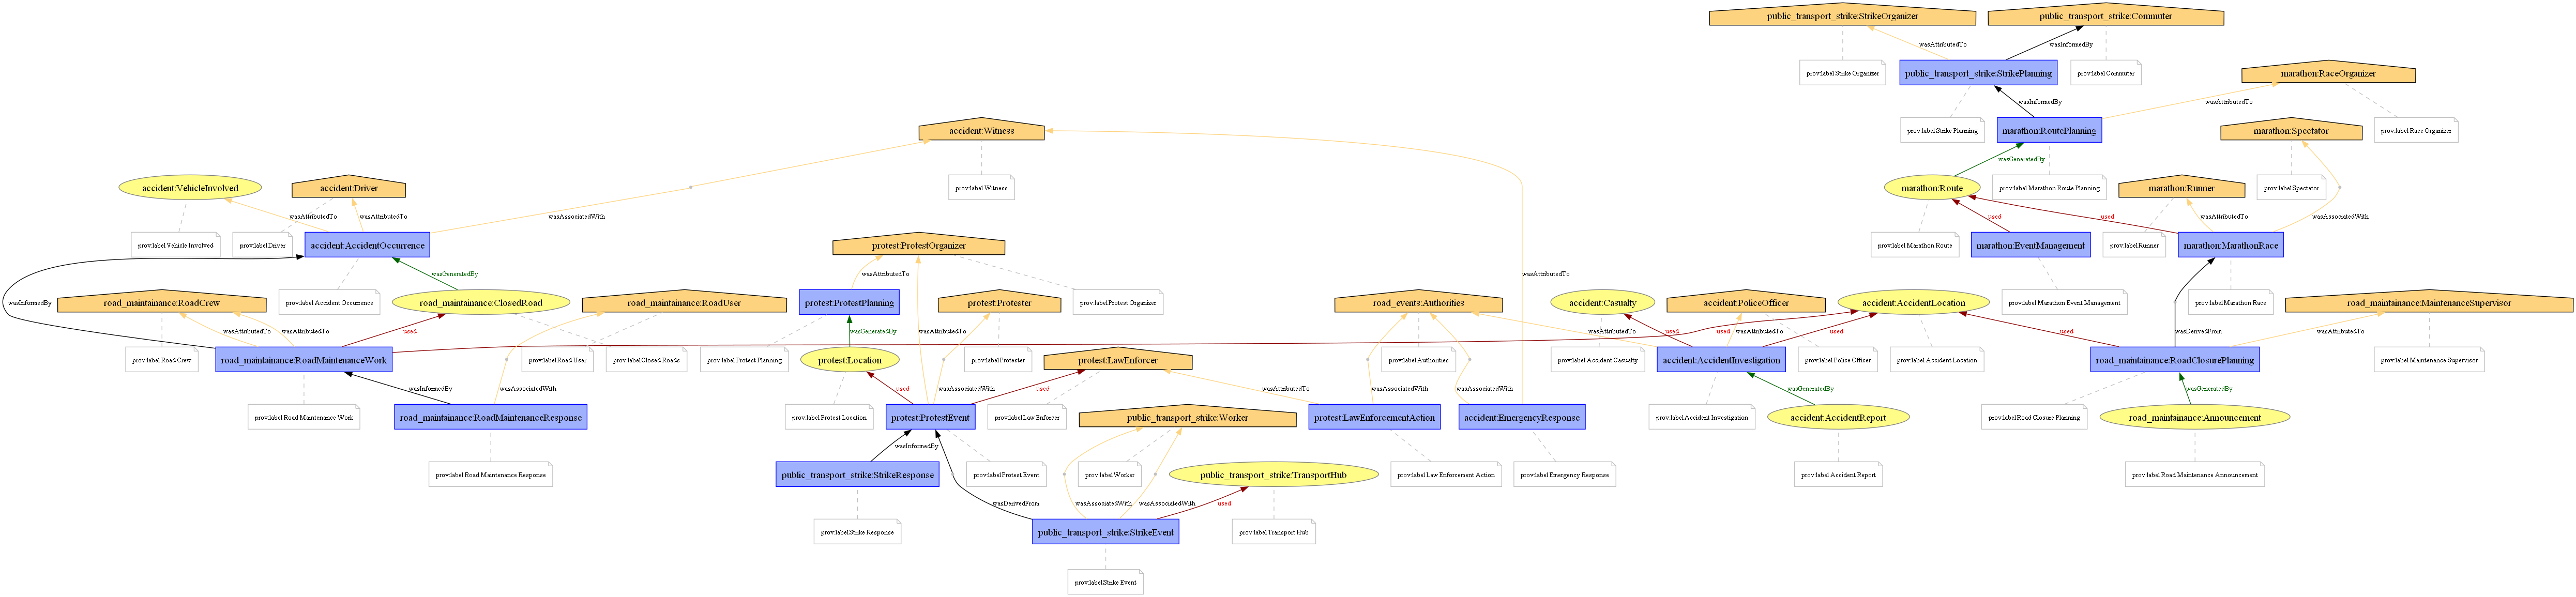

In [10]:
Image('leeds-accident-prov.png')

2. Compute the PageRank value for all the nodes of this network. What do these PR values tell you about the events in the city?

In [11]:
# Convert ProvDocument to MultiDiGraph
g = prov_to_graph(doc)

In [12]:
print(g.number_of_nodes())
print(g.number_of_edges())

40
44


In [13]:
def plot_pagerank(graph, pagerank):
    fig, ax = plt.subplots(1, 1, figsize=(8, 7))

    labels = dict(zip(set(graph.nodes()), range(len(set(graph.nodes())))))
    node_color = list(pagerank.values())
    nx.draw(graph, with_labels=True, alpha=0.8, arrows=False, node_size=300, node_color=node_color, cmap=plt.cm.viridis, labels=labels)

    # adding color bar for pagerank importances
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('viridis'), norm=colors.Normalize(vmin=min(node_color), vmax=max(node_color)))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(sm, cax=cax)

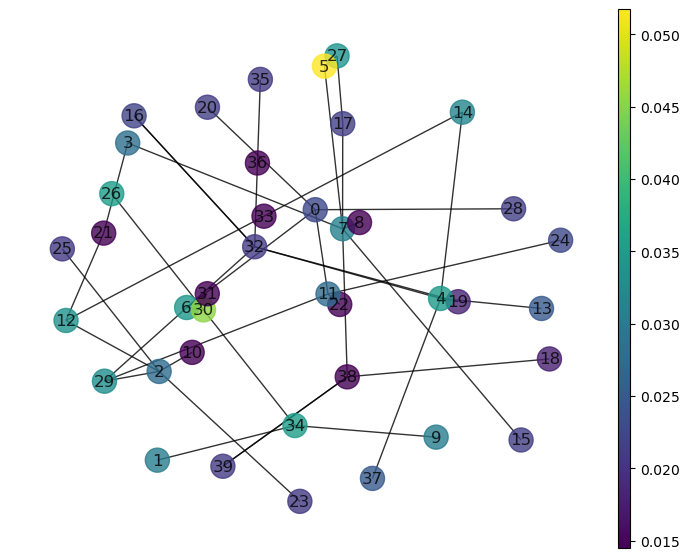

In [14]:
pagerank = nx.pagerank(g, alpha=0.9)
plot_pagerank(g, pagerank)

In [15]:
pagerank_sorted_desc = dict(sorted(pagerank.items(), key=lambda item: item[1], reverse=True))
node_degree = {k: v for k, v in g.degree(pagerank_sorted_desc.keys())}

Text(0, 0.5, 'PageRank value')

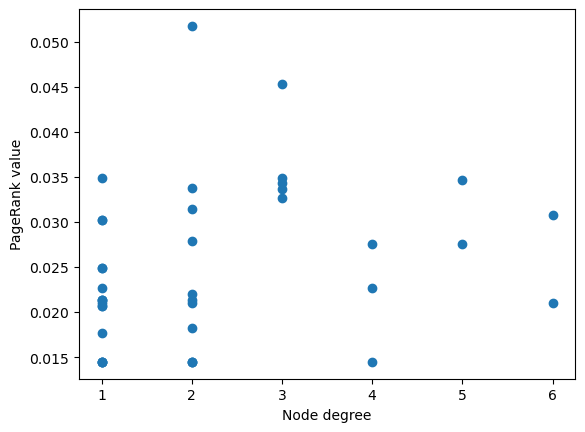

In [16]:
x = node_degree.values()
y = pagerank_sorted_desc.values()

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_xlabel('Node degree')
ax.set_ylabel('PageRank value')

In [41]:
top_nodes = list(pagerank_sorted_desc.keys())[:3]

# Print the names of the most central nodes
print("Most central nodes based on PageRank:")
for node in top_nodes:
    print(node)

Most central nodes based on PageRank:
agent(protest:ProtestOrganizer, [prov:label="Protest Organizer"])
activity(marathon:RoutePlanning, -, -, [prov:label="Marathon Route Planning"])
activity(public_transport_strike:StrikePlanning, -, -, [prov:label="Strike Planning"])


3. Train and evaluate TransE, RotatE and GCN embeddings for the previous provenance network, visualise them, and evaluate them with the CoDExMedium dataset. Tune hyperparameters to improve performance. What could these embeddings be used for from a practical point of view? What kind of problems could they help address?

#### TransE

In [17]:
#Reference : https://wasit7.medium.com/tutorial-knowledge-graph-embedding-with-pykeen-22d3b7847cea

In [18]:
dataset = CoDExMedium(create_inverse_triples=False)
codex_triples_factory = dataset.training
codex_triples_factory

TriplesFactory(num_entities=17050, num_relations=51, create_inverse_triples=False, num_triples=185584, path="C:\Users\Akshay Saraf\.data\pykeen\datasets\codexmedium\train.txt")

In [19]:
# Function to extract relationships from the graph
def extract_relationships(g):
    subjects = []
    predicates = []
    objects = []

    for node, _, attrs in g.edges(data=True):
        subjects.append(node)
        objects.append(list(g.successors(node))[0])
        if 'relation' in attrs:
            relation = attrs['relation']
            # Check the type of the relation
            if isinstance(relation, ProvUsage):
                # Handle ProvUsage relation
                predicate = 'Used'
            elif isinstance(relation, ProvGeneration):
                # Handle ProvGeneration relation
                predicate = 'GeneratedBy'
            elif isinstance(relation, ProvAttribution):
                # Handle ProvAttribution relation
                predicate = 'AttributedTo'
            elif isinstance(relation, ProvAssociation):
                # Handle ProvAssociation relation
                predicate = 'AssociatedWith'
            elif isinstance(relation, ProvCommunication):
                # Handle ProvCommunication relation
                predicate = 'InformedBy'
            elif isinstance(relation, ProvDerivation):
                # Handle ProvDerivation relation
                predicate = 'DerivedFrom'
            else:
                # Unknown relation type
                predicate = None

            if predicate:
                predicates.append(predicate)
            else:
                predicates.append(None)
        else:
            predicates.append(None)

    #Retreive the identifiers from the subject and object.
    subject_identifiers = [node.identifier.localpart for node in subjects]
    object_identifiers = [obj.identifier.localpart for obj in objects]

    return subject_identifiers, object_identifiers, predicates

# Extract relationships from the graph representation
subjects, objects, predicates = extract_relationships(g)

# Create a DataFrame
df = pd.DataFrame({'subject': subjects, 'predicate': predicates, 'object': objects})

# Display the DataFrame
df.head()

,subject,predicate,object
0,AccidentReport,GeneratedBy,AccidentInvestigation
1,Route,GeneratedBy,RoutePlanning
2,ClosedRoad,GeneratedBy,AccidentOccurrence
3,Announcement,GeneratedBy,RoadClosurePlanning
4,Location,GeneratedBy,ProtestPlanning


In [20]:
triples_factory = TriplesFactory.from_labeled_triples(
    triples=df[['subject', 'predicate', 'object']].values,
)

triples_factory

TriplesFactory(num_entities=29, num_relations=6, create_inverse_triples=False, num_triples=37)

In [21]:
transE_pipeline = pipeline(
    training =codex_triples_factory,
    testing =triples_factory,
    model='TransE',
    model_kwargs=dict(embedding_dim=50),
    optimizer_kwargs=dict(lr=1.0e-2),
    training_kwargs=dict(num_epochs=10, use_tqdm_batch=False),
    random_seed=1,
    device='gpu',
    training_loop='sLCWA',
    negative_sampler=BasicNegativeSampler
)

No cuda devices were available. The model runs on CPU


Training epochs on cpu:   0%|          | 0/10 [00:00<?, ?epoch/s]

Evaluating on cpu:   0%|          | 0.00/37.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 2.12s seconds


C:\Users\Akshay Saraf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Akshay Saraf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

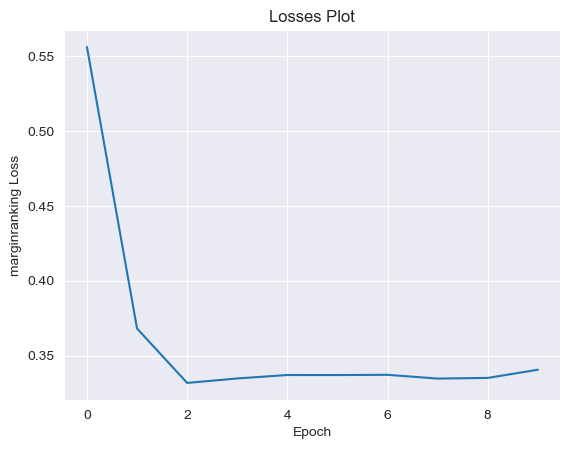

In [22]:
transE_pipeline.plot_losses()

In [23]:
mrr = transE_pipeline.get_metric('mrr')
hits_at_10 = transE_pipeline.get_metric('hits@k')
print("The Mean Reciprocal Rank is: " + str(mrr))
print("The Hits at 10 is: " + str(hits_at_10))

The Mean Reciprocal Rank is: 0.0002234481216873974
The Hits at 10 is: 0.0


In [43]:
#Hyperparameter Tuning

embedding_dims = [50, 75, 100]
learning_rates = [0.01] #Using only one learning rate to reduce the computation time. We can use a search space of [0.001,0.01,0.1]

best_mrr = 0
best_hyperparameters = {}

for embedding_dim in embedding_dims:
    for learning_rate in learning_rates:
        transE_pipeline = pipeline(
            training =codex_triples_factory,
            testing =triples_factory,
            model='TransE',
            model_kwargs=dict(embedding_dim=embedding_dim),
            optimizer_kwargs=dict(lr=learning_rate),
            training_kwargs=dict(num_epochs=10, use_tqdm_batch=False),
            random_seed=1,
            device='gpu',
            training_loop='sLCWA',
            negative_sampler=BasicNegativeSampler
        )

        mrr = transE_pipeline.get_metric('mrr')

        # Check if this configuration is better than previous ones
        if mrr > best_mrr:
            best_mrr = mrr
            best_hyperparameters = {'embedding_dim': embedding_dim, 'learning_rate': learning_rate}
            best_model_transE = transE_pipeline

print("Best hyperparameters:", best_hyperparameters)
print("Best MRR:", best_mrr)

INFO:pykeen.pipeline.api:Using device: gpu
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cpu:   0%|          | 0/10 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Evaluating on cpu:   0%|          | 0.00/37.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.30s seconds
INFO:pykeen.pipeline.api:Using device: gpu
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cpu:   0%|          | 0/10 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Evaluating on cpu:   0%|          | 0.00/37.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.42s seconds
INFO:pykeen.pipeline.api:Using device: gpu
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cpu:   0%|          | 0/10 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Evaluating on cpu:   0%|          | 0.00/37.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.71s seconds


Best hyperparameters: {'embedding_dim': 50, 'learning_rate': 0.01}
Best MRR: 0.0005536085227504373


C:\Users\Akshay Saraf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Akshay Saraf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

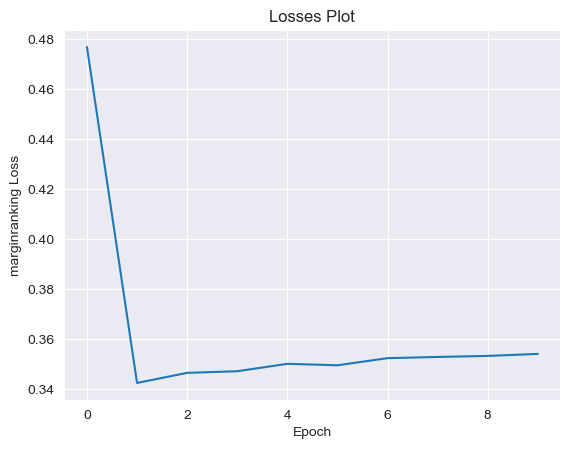

In [44]:
best_model_transE.plot_losses()

In [45]:
mrr = best_model_transE.get_metric('mrr')
hits_at_10 = best_model_transE.get_metric('hits@k')
print("The Mean Reciprocal Rank is: " + str(mrr))
print("The Hits at 10 is: " + str(hits_at_10))

The Mean Reciprocal Rank is: 0.0005536085227504373
The Hits at 10 is: 0.0


#### RotatE

In [29]:
pipeline_result_ro = pipeline(
    training =codex_triples_factory,
    testing =triples_factory,
    model='RotatE',
    model_kwargs=dict(embedding_dim=50),
    optimizer_kwargs=dict(lr=1.0e-2),
    training_kwargs=dict(num_epochs=10, use_tqdm_batch=False),
    evaluation_kwargs=dict(use_tqdm=True),
    random_seed=1,
    training_loop='sLCWA',
    negative_sampler=BasicNegativeSampler,
    evaluator = RankBasedEvaluator
)

INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/10 [00:00<?, ?epoch/s]

Evaluating on cpu:   0%|          | 0.00/37.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 2.19s seconds


C:\Users\Akshay Saraf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Akshay Saraf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

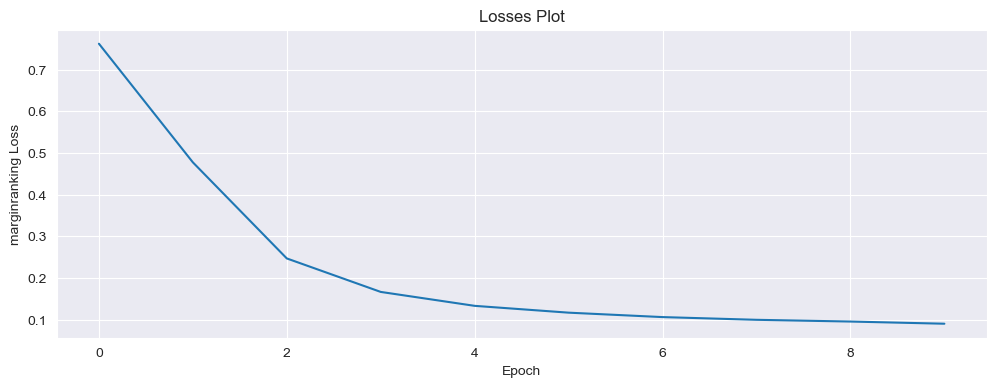

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))
pipeline_result_ro.plot_losses()

In [31]:
mrr = pipeline_result_ro.get_metric('mrr')
hits_at_10 = pipeline_result_ro.get_metric('hits@k')
print("The Mean Reciprocal Rank is: " + str(mrr))
print("The Hits at 10 is: " + str(hits_at_10))

The Mean Reciprocal Rank is: 0.00016071250138338655
The Hits at 10 is: 0.0


In [53]:
#Hyperparameter Tuning

embedding_dims = [50, 75, 100]
learning_rates = [0.01] #Using only one learning rate to reduce the computation time. We can use a search space of [0.001,0.01,0.1]

best_mrr = 0
best_hyperparameters = {}
best_model = None

for embedding_dim in embedding_dims:
    for learning_rate in learning_rates:
        pipeline_result_ro = pipeline(
            training =codex_triples_factory,
            testing =triples_factory,
            model='RotatE',
            model_kwargs=dict(embedding_dim=embedding_dim),
            optimizer_kwargs=dict(lr=learning_rate),
            training_kwargs=dict(num_epochs=10, use_tqdm_batch=False),
            evaluation_kwargs=dict(use_tqdm=True),
            random_seed=1,
            training_loop='sLCWA',
            negative_sampler=BasicNegativeSampler,
            evaluator = RankBasedEvaluator
        )

        mrr = pipeline_result_ro.get_metric('mrr')

        # Check if this configuration is better than previous ones
        if mrr > best_mrr:
            best_mrr = mrr
            best_hyperparameters = {'embedding_dim': embedding_dim, 'learning_rate': learning_rate}
            best_model_rotatE = pipeline_result_ro

print("Best hyperparameters:", best_hyperparameters)
print("Best MRR:", best_mrr)

INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cpu:   0%|          | 0/10 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Evaluating on cpu:   0%|          | 0.00/37.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.47s seconds
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cpu:   0%|          | 0/10 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Evaluating on cpu:   0%|          | 0.00/37.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.51s seconds
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cpu:   0%|          | 0/10 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Evaluating on cpu:   0%|          | 0.00/37.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.55s seconds


Best hyperparameters: {'embedding_dim': 75, 'learning_rate': 0.01}
Best MRR: 0.002996644238010049


C:\Users\Akshay Saraf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Akshay Saraf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

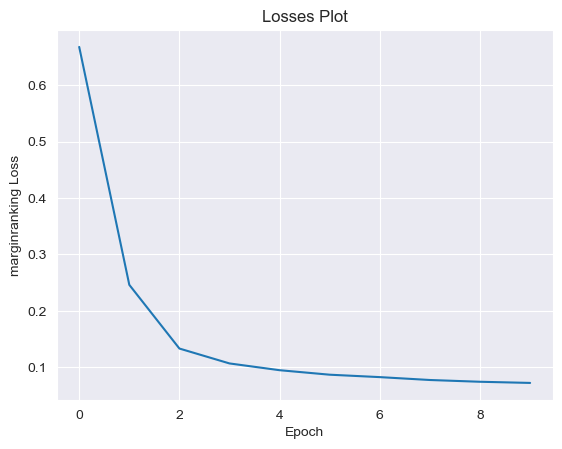

In [54]:
best_model_rotatE.plot_losses()

In [55]:
mrr = best_model_rotatE.get_metric('mrr')
hits_at_10 = best_model_rotatE.get_metric('hits@k')
print("The Mean Reciprocal Rank is: " + str(mrr))
print("The Hits at 10 is: " + str(hits_at_10))

The Mean Reciprocal Rank is: 0.002996644238010049
The Hits at 10 is: 0.013513513513513514


#### GCN

In [36]:
codex_triples_factory = CoDExMedium(create_inverse_triples=True).training
codex_triples_factory

TriplesFactory(num_entities=17050, num_relations=102, create_inverse_triples=True, num_triples=185584, path="C:\Users\Akshay Saraf\.data\pykeen\datasets\codexmedium\train.txt")

In [37]:
#Hyperparameter Tuning

embedding_dims = [50, 75, 100]
learning_rates = [0.01] #Using only one learning rate to reduce the computation time. We can use a search space of [0.001,0.01,0.1]

best_mrr = 0
best_hyperparameters = {}
best_model = None

for embedding_dim in embedding_dims:
    for learning_rate in learning_rates:
        pipeline_result_gcn = pipeline(
            training = codex_triples_factory,
            testing= triples_factory,
            model=CompGCN,
            model_kwargs=dict(embedding_dim=50),
            optimizer_kwargs=dict(lr=1.0e-2),
            training_kwargs=dict(num_epochs=10, use_tqdm_batch=False),
            evaluation_kwargs=dict(use_tqdm=True),
            random_seed=1,
            training_loop='sLCWA',
            negative_sampler=BasicNegativeSampler,
            evaluator = RankBasedEvaluator
        )

        mrr = pipeline_result_gcn.get_metric('mrr')

        # Check if this configuration is better than previous ones
        if mrr > best_mrr:
            best_mrr = mrr
            best_hyperparameters = {'embedding_dim': embedding_dim, 'learning_rate': learning_rate}
            best_model = pipeline_result_gcn

print("Best hyperparameters:", best_hyperparameters)
print("Best MRR:", best_mrr)

INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cpu:   0%|          | 0/10 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/1449 (0.07%) batches).


Evaluating on cpu:   0%|          | 0.00/37.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.14s seconds
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cpu:   0%|          | 0/10 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/1449 (0.07%) batches).


Evaluating on cpu:   0%|          | 0.00/37.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.13s seconds
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cpu:   0%|          | 0/10 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/1449 (0.07%) batches).


Evaluating on cpu:   0%|          | 0.00/37.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.28s seconds


Best hyperparameters: {'embedding_dim': 100, 'learning_rate': 0.01}
Best MRR: 0.00030246778624132276


C:\Users\Akshay Saraf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Akshay Saraf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

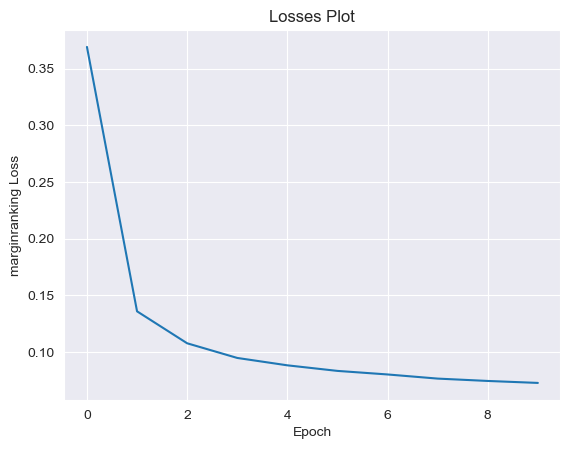

In [38]:
best_model.plot_losses()

In [39]:
mrr = best_model.get_metric('mrr')
hits_at_10 = best_model.get_metric('hits@k')
print("The Mean Reciprocal Rank is: " + str(mrr))
print("The Hits at 10 is: " + str(hits_at_10))

The Mean Reciprocal Rank is: 0.00030246778624132276
The Hits at 10 is: 0.0
